In [1]:
data = [1, 2, 3, 4, 5]

print(data[:-1])

[1, 2, 3, 4]


In [1]:
import xarray_beam as xbeam
import xarray
import os
from pathlib import Path

DIR_NAME = os.path.join(os.path.dirname(os.path.abspath(os.getcwd())), 'resource')
folder = Path(DIR_NAME)
file_path = folder / '512x256' / '2013-01-01_2023-01-01.zarr'
ds, chunk = xbeam.open_zarr(file_path)
print(ds.nbytes / (10**9))

24.536812296


In [2]:
print(chunk)

{'time': 256, 'latitude': 36, 'longitude': 36, 'level': 8}


In [4]:
print(ds['total_precipitation'])

<xarray.DataArray 'total_precipitation' (time: 87649, latitude: 36,
                                         longitude: 36)>
[113593104 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 20.04 20.74 21.45 22.15 ... 43.24 43.95 44.65
  * longitude  (longitude) float64 115.3 116.0 116.7 117.4 ... 138.5 139.2 139.9
  * time       (time) datetime64[ns] 2013-01-01 ... 2023-01-01
Attributes:
    long_name:   Total precipitation
    short_name:  tp
    units:       m


In [3]:
import pandas as pd
import numpy as np

start_date = pd.to_datetime('2021-01-01')
end_date = pd.to_datetime('2021-01-03')

source_dataset = ds.sel(time=slice(start_date, end_date))

print(source_dataset)

<xarray.Dataset>
Dimensions:                  (time: 49, latitude: 36, longitude: 36, level: 8)
Coordinates:
  * latitude                 (latitude) float64 20.04 20.74 ... 43.95 44.65
  * level                    (level) int64 50 100 250 500 600 700 850 925
  * longitude                (longitude) float64 115.3 116.0 ... 139.2 139.9
  * time                     (time) datetime64[ns] 2021-01-01 ... 2021-01-03
Data variables:
    10m_u_component_of_wind  (time, latitude, longitude) float32 ...
    10m_v_component_of_wind  (time, latitude, longitude) float32 ...
    2m_temperature           (time, latitude, longitude) float32 ...
    geopotential             (time, level, latitude, longitude) float32 ...
    mean_sea_level_pressure  (time, latitude, longitude) float32 ...
    specific_humidity        (time, level, latitude, longitude) float32 ...
    temperature              (time, level, latitude, longitude) float32 ...
    total_cloud_cover        (time, latitude, longitude) float32 ..

In [4]:
print(list(source_dataset.keys()))

['10m_u_component_of_wind', '10m_v_component_of_wind', '2m_temperature', 'geopotential', 'mean_sea_level_pressure', 'specific_humidity', 'temperature', 'total_cloud_cover', 'total_precipitation', 'u_component_of_wind', 'v_component_of_wind', 'vertical_velocity']


In [5]:
dataset = source_dataset['2m_temperature']
data = dataset.values - 273.15
data = data[0]
print(data.shape)

(36, 36)


In [6]:
print(dataset.longitude.values)

print(dataset.latitude.values)

[115.3125   116.015625 116.71875  117.421875 118.125    118.828125
 119.53125  120.234375 120.9375   121.640625 122.34375  123.046875
 123.75     124.453125 125.15625  125.859375 126.5625   127.265625
 127.96875  128.671875 129.375    130.078125 130.78125  131.484375
 132.1875   132.890625 133.59375  134.296875 135.       135.703125
 136.40625  137.109375 137.8125   138.515625 139.21875  139.921875]
[20.0390625 20.7421875 21.4453125 22.1484375 22.8515625 23.5546875
 24.2578125 24.9609375 25.6640625 26.3671875 27.0703125 27.7734375
 28.4765625 29.1796875 29.8828125 30.5859375 31.2890625 31.9921875
 32.6953125 33.3984375 34.1015625 34.8046875 35.5078125 36.2109375
 36.9140625 37.6171875 38.3203125 39.0234375 39.7265625 40.4296875
 41.1328125 41.8359375 42.5390625 43.2421875 43.9453125 44.6484375]


In [14]:
lat_indices = np.where((source_dataset.latitude >= 33) & (source_dataset.latitude <= 43))[0]
lon_indices = np.where((source_dataset.longitude >= 124) & (source_dataset.longitude <= 132))[0]

print(lat_indices)
print(lon_indices)
print((lat_indices * 36 + np.expand_dims(lon_indices, axis=1)).shape )

data = data.flatten()

data[lat_indices * 36 + np.expand_dims(lon_indices, axis=1)] = 100

data = data.reshape(36, 36)

print(data.shape)


[19 20 21 22 23 24 25 26 27 28 29 30 31 32]
[13 14 15 16 17 18 19 20 21 22 23]
(11, 14)
(36, 36)


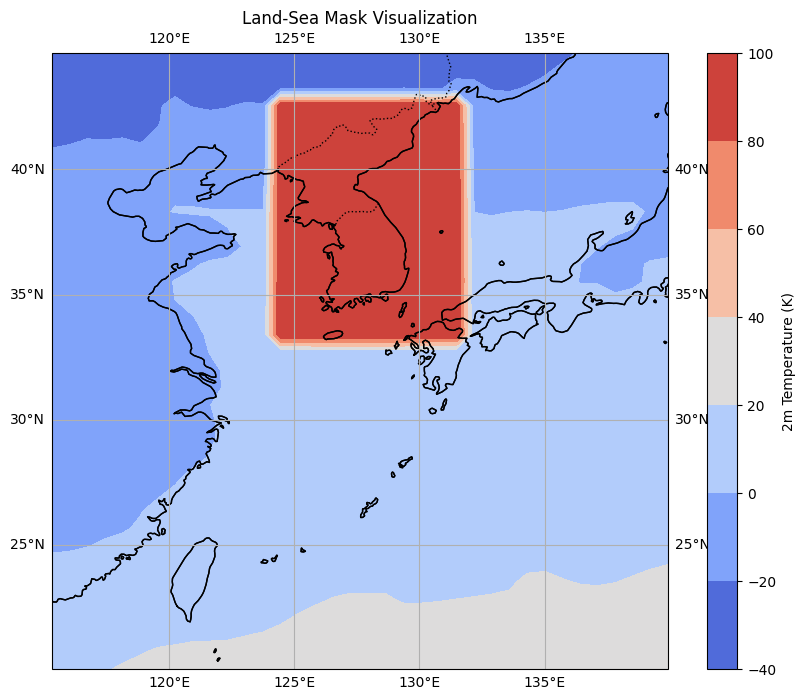

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# 땅과 바다 구분을 위해, 0.5를 기준으로 땅(1)과 바다(0)를 구분
# cmap을 'binary'로 설정하여 땅과 바다를 명확하게 구분
plt.contourf(dataset.longitude.values, dataset.latitude.values, data, transform=ccrs.PlateCarree(), cmap='coolwarm')

plt.colorbar(label='2m Temperature (K)')

# 기본 지도 추가
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

plt.title('Land-Sea Mask Visualization')
plt.show()